# Rental Bike Project

## Problem Definition

The problem at hand revolves around predicting bike trip durations and the number of incoming and outgoing trips on a daily basis. The predictions will be based on various environmental and seasonal settings, which are likely to influence the patterns of bike usage. By understanding and modeling these influential factors, we aim to gain valuable insights into the dynamics of bike sharing systems and improve the overall efficiency and user experience.

Bike sharing systems have become increasingly popular in urban areas, providing a convenient and sustainable mode of transportation for residents and visitors alike. These systems often involve a fleet of bicycles distributed across multiple docking stations throughout the city. Users can rent a bike from one station and return it to another, enabling flexible point-to-point travel.

To effectively manage and optimize the bike sharing system, it is essential to have a reliable prediction model that can anticipate the demand for bikes at different stations and during different time intervals. By accurately forecasting trip durations and trip volumes, system operators can make informed decisions about resource allocation, station maintenance, and capacity planning.
## Table of Contents

##### 1-Data Collection
- Importing the necessary libraries & packages
- Loading data
- Data representation
##### 2-Exploratory Data Analysis (EDA)
- Data visualization
- Trends
- Data analysis
##### 3-Data Preprocessing
- Outlier analysis
- Data cleaning
- Feature scaling 
##### 4-Graph Creation
- Node features
- Edge creation
- Static & dynamic edges
- Graph creation
##### 5-Train & Test Split 
##### 6-Optimization
- Dimensionality reduction
- hyperparameter optimization
##### 7-Model Development
##### 8-Cross Validation Prediction
##### 9-Models Performances
- Optimization impacts on models
- Models comparison
##### 10-Model Evaluation Metrics
##### 11-Conclusion 


## Goal and Hypothesis

The primary goal of this project is to develop a predictive model that can accurately forecast bike trip durations and the number of incoming and outgoing trips on a daily basis in a bike sharing system. The model will utilize environmental and seasonal settings as input features to capture the various factors that influence bike usage patterns. By achieving this goal, we aim to enhance the efficiency and reliability of the bike sharing system, leading to improved user satisfaction and a more sustainable and accessible transportation option for urban communities.

Based on the graph dataset and the available environmental and seasonal settings, we hypothesize that certain factors will significantly impact bike trip durations and the volume of incoming and outgoing trips. We expect that variables such as day of the week, time of day, and seasonal variations will play a crucial role in determining bike usage patterns.

By testing and analyzing these hypotheses through data exploration and modeling techniques, we aim to gain a deeper understanding of the relationships between the input features and the target variables. This knowledge will allow us to build a robust predictive model that accurately captures the dynamics of the bike sharing system and aids in making informed decisions for system optimization and planning.

Let's start our journey by collecting and exploring the data to uncover valuable insights for our rental bike project!

##### 1 - Data Collection

- Importing necessary libraries


In [3]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.utils.extmath import cartesian
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
from datetime import datetime, timedelta
import calendar
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt

- Loading data

In [4]:
#read the data file
trips = pd.read_csv("../Data/bikeshare-data/bikeshare-test.csv")
trips.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,249955060,41,4/1/2023 0:00,4/1/2023 0:41,4643,34.072620,-118.449440,4643,34.072620,-118.449440,22398,30,Round Trip,Monthly Pass,electric
1,249954734,11,4/1/2023 0:00,4/1/2023 0:11,4643,34.072620,-118.449440,4613,34.069752,-118.445351,22304,30,One Way,Monthly Pass,electric
2,249954667,2,4/1/2023 0:02,4/1/2023 0:04,4523,34.068748,-118.309280,4538,34.065430,-118.308823,6591,30,One Way,Monthly Pass,standard
3,249954776,12,4/1/2023 0:03,4/1/2023 0:15,3034,34.042061,-118.263382,4491,34.047440,-118.247940,13897,365,One Way,Annual Pass,standard
4,249954777,11,4/1/2023 0:04,4/1/2023 0:15,3056,34.037460,-118.265381,4491,34.047440,-118.247940,15488,30,One Way,Monthly Pass,standard


- Data representation

In [5]:
#rename columns
trips.rename(columns={"trip_id":"id", "start_time":"start_date", "end_time":"end_date", 
"start_station": "start_station_id", "start_lon":"start_lng", 
"end_station":"end_station_id", "end_lon":"end_lng"}, inplace=True)

#drop unnecessary columns
cols_to_drop = ["bike_type", "passholder_type", "trip_route_category", "plan_duration"]
trips.drop(cols_to_drop, axis=1 , inplace=True) 

#datetime format
trips['start_date'] = pd.to_datetime(trips['start_date'], format='%m/%d/%Y %H:%M')
trips['start_date'] = trips['start_date'].dt.strftime('%Y-%m-%d %H:%M:%S')

trips['end_date'] = pd.to_datetime(trips['end_date'], format='%m/%d/%Y %H:%M')
trips['end_date'] = trips['end_date'].dt.strftime('%Y-%m-%d %H:%M:%S')

# #split date columns
#trips['start_year'] = trips['start_date'].apply(lambda x: x.split()[0].split('-')[0])
trips['start_month'] = trips['start_date'].apply(lambda x: x.split()[0].split('-')[1])
trips['start_day'] = trips['start_date'].apply(lambda x: x.split()[0].split('-')[2])
trips['start_hour'] = trips['start_date'].apply(lambda x: x.split()[1].split(':')[0])
trips['start_minute'] = trips['start_date'].apply(lambda x: x.split()[1].split(':')[1])

#trips['end_year'] = trips['end_date'].apply(lambda x: x.split()[0].split('-')[0])
trips['end_month'] = trips['end_date'].apply(lambda x: x.split()[0].split('-')[1])
trips['end_day'] = trips['end_date'].apply(lambda x: x.split()[0].split('-')[2])
trips['end_hour'] = trips['end_date'].apply(lambda x: x.split()[1].split(':')[0])
trips['end_minute'] = trips['end_date'].apply(lambda x: x.split()[1].split(':')[1])

#print head,shape,type,..
print(trips.info())
print(trips.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109436 entries, 0 to 109435
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                109436 non-null  int64  
 1   duration          109436 non-null  int64  
 2   start_date        109436 non-null  object 
 3   end_date          109436 non-null  object 
 4   start_station_id  109436 non-null  int64  
 5   start_lat         109417 non-null  float64
 6   start_lng         109417 non-null  float64
 7   end_station_id    109436 non-null  int64  
 8   end_lat           107695 non-null  float64
 9   end_lng           107695 non-null  float64
 10  bike_id           109436 non-null  int64  
 11  start_month       109436 non-null  object 
 12  start_day         109436 non-null  object 
 13  start_hour        109436 non-null  object 
 14  start_minute      109436 non-null  object 
 15  end_month         109436 non-null  object 
 16  end_day           10

##### 2 - Exploratory Data Analysis(EDA)

- Data visualization


<Axes: xlabel='index', ylabel='trips_per_hour'>

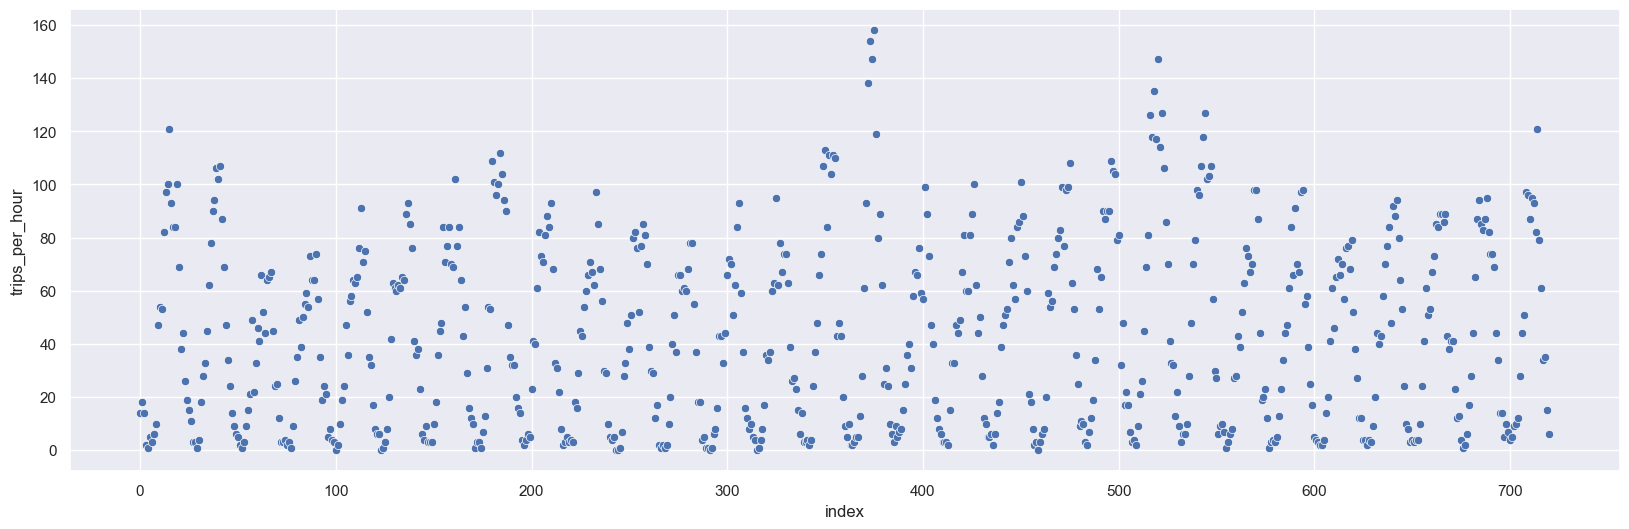

In [6]:
#trips per hour in a month

sns.set(rc={'figure.figsize':(20,6)})
trips["start_date"] = pd.to_datetime(trips["start_date"], format="%Y-%m-%d %H:%M:%S")
trips["end_date"] = pd.to_datetime(trips["end_date"], format="%Y-%m-%d %H:%M:%S")

start_date = datetime.strptime("2023-04-01 00:00:00", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2023-05-01 00:00:00", "%Y-%m-%d %H:%M:%S")
interval = timedelta(minutes=60)
bucket_elements = []
while start_date <= end_date:
    bucket_elements.append(trips[((start_date + interval) >= trips["end_date"])
                                & (start_date <= trips["end_date"])].shape[0])
    start_date += interval

sns.scatterplot(x="index", y="trips_per_hour", data=pd.DataFrame(bucket_elements, columns=["trips_per_hour"]).reset_index())


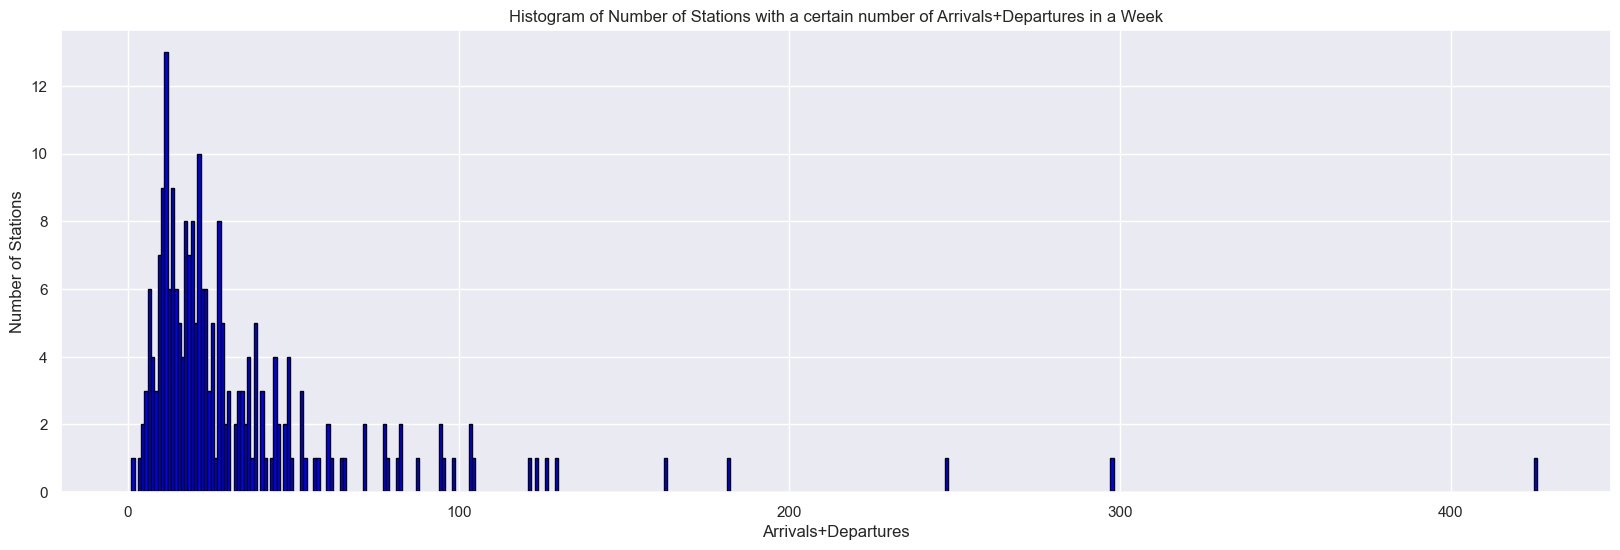

In [40]:
# Histogram of Number of Stations with a certain number of Arrivals+Departures in a Week (3 months)

trips['arrivals_departures'] = trips.groupby('start_station_id')['start_date'].transform('count') + trips.groupby('end_station_id')['end_date'].transform('count')
trips['week'] = trips['start_date'].dt.to_period('W')

weekly_counts = trips.groupby(['week', 'start_station_id']).size().reset_index(name='counts')
monthly_average = weekly_counts.groupby('start_station_id')['counts'].mean().reset_index(name='average_counts')
counts = monthly_average['average_counts']

bins = np.arange(counts.min(), counts.max() + 2)  
plt.hist(counts, bins=bins, color='blue', edgecolor='black')
plt.xlabel('Arrivals+Departures')
plt.ylabel('Number of Stations')
plt.title('Histogram of Number of Stations with a certain number of Arrivals+Departures in a Week')
plt.show()

#### The histogram provides a clear overview of the distribution of arrivals and departures at various bike-sharing stations during a week. The visual analysis shows that the majority of stations have a modest number of weekly trips, with only a few stations experiencing a much higher volume of activity.

desired_month = "06"

month_data = trips[trips['start_month'] == desired_month]
weekly_counts = trips.groupby(['start_station_id', month_data["start_date"].dt.week]).size().reset_index(name='counts')
monthly_average = weekly_counts.groupby('start_station_id')['counts'].mean().reset_index(name='average_counts')
counts = monthly_average['average_counts']

bins = np.arange(counts.min(), counts.max() + 2)  
plt.hist(counts, bins=bins, color='blue', edgecolor='black')
plt.xlabel('Arrivals+Departures')
plt.ylabel('Number of Stations')
plt.title(f'Average Arrivals + Departures per Week in Month {desired_month}')
plt.show()


- Trends

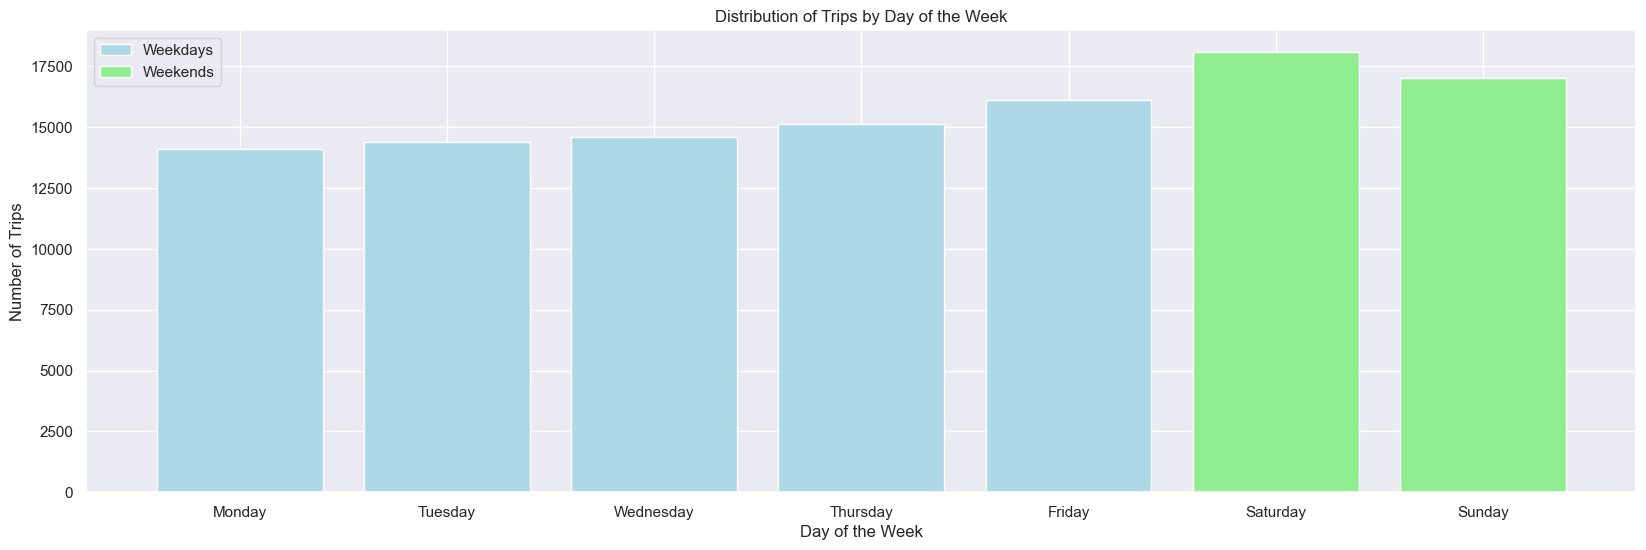

In [9]:
#creating monthly,yearly,daily,weekly plots and visuals (3 months)
#weekly
trips['start_date'] = pd.to_datetime(trips['start_date'])
trips['weekday'] = trips['start_date'].dt.strftime('%A')
trips_by_weekday = trips.groupby('weekday').size()

weekdays_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_by_weekday = trips_by_weekday.reindex(weekdays_order)

weekdays_trips = trips_by_weekday.loc['Monday':'Friday']
weekends_trips = trips_by_weekday.loc['Saturday':'Sunday']

plt.bar(weekdays_trips.index, weekdays_trips, label='Weekdays', color='lightblue')
plt.bar(weekends_trips.index, weekends_trips, label='Weekends', color='lightgreen')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips by Day of the Week')
plt.legend()
plt.show()

#### The bar plot effectively illustrates the distribution of bike trips over a three-month period based on the day of the week. It reveals the distinct patterns between weekdays and weekends, with higher demand for bike-sharing on weekends and a gradual increase in trips during the workweek.

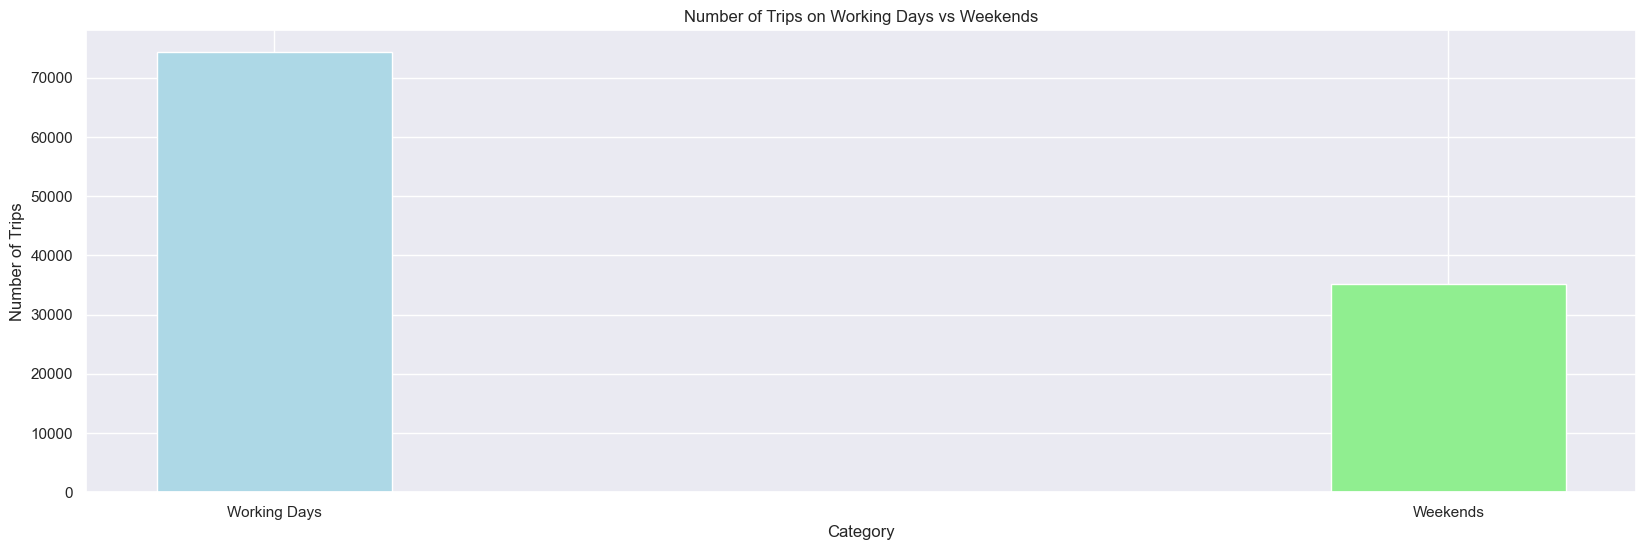

In [10]:
#working days vs weekend (3 months)
working_days_trips = weekdays_trips.sum()
weekend_trips = weekends_trips.sum()

plt.bar(['Working Days', 'Weekends'], [working_days_trips, weekend_trips], color=['lightblue', 'lightgreen'], width=0.2)
plt.xlabel('Category')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Working Days vs Weekends')
plt.show()

#### The bar plot effectively highlights the difference in bike-sharing demand between working days and weekends over a three-month period. The data analysis suggests that bike trips are more frequent and popular on working days due to higher commuting and daily transportation requirements. On the other hand, bike-sharing experiences reduced usage during weekends when recreational activities and reduced work commitments are more prevalent.

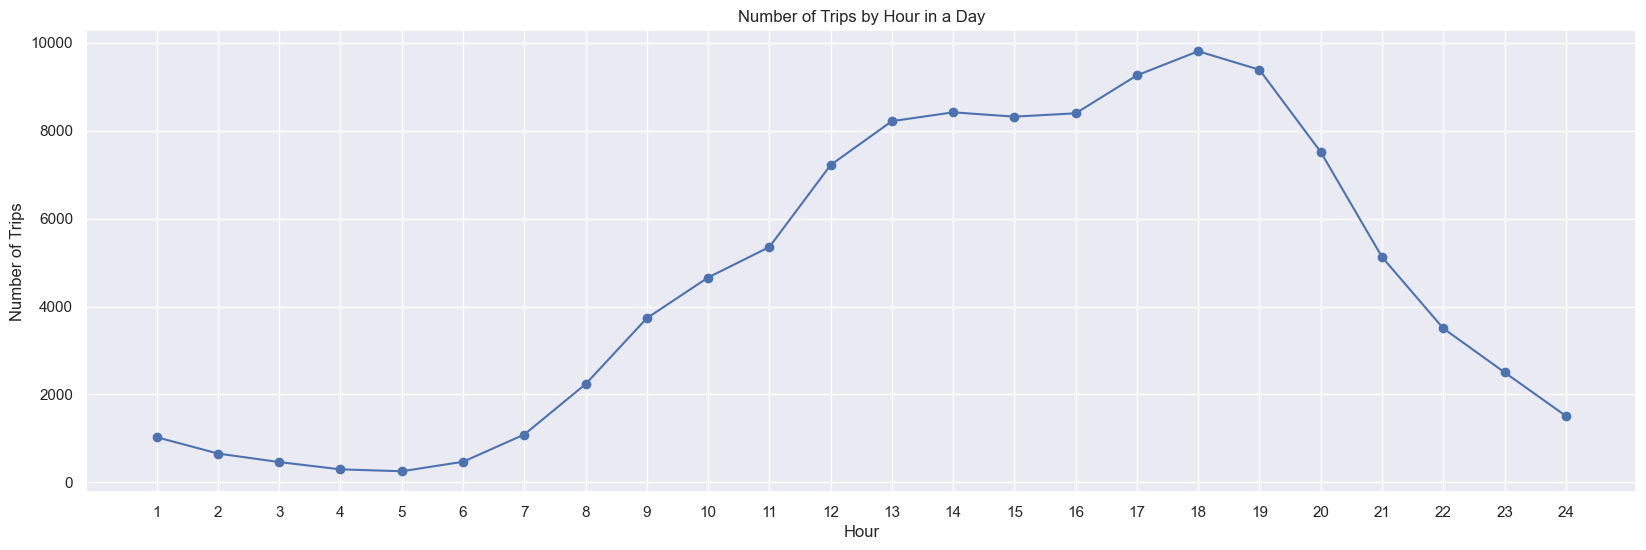

In [11]:
#daily (3 months)
hourly_counts = trips.groupby('start_hour').size()
hours = range(1,25)
plt.plot(hours, hourly_counts, marker='o')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Hour in a Day')
plt.xticks(range(1,25))
plt.show()

#### the line plot effectively illustrates the temporal distribution of bike trips throughout the day over a three-month period. The data analysis showcases distinctive trends in bike-sharing demand during different hours, with significant peaks observed during the morning and evening rush hours.

- Data analysis

In [12]:
#discover patterns and relationships

##### 3 - Data Preprocessing

- Outlier analysis


In [13]:
#TODO discover outliers and decide to remove or not

- Data cleaning

In [14]:
#type casting & type checking
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109436 entries, 0 to 109435
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   109436 non-null  int64         
 1   duration             109436 non-null  int64         
 2   start_date           109436 non-null  datetime64[ns]
 3   end_date             109436 non-null  datetime64[ns]
 4   start_station_id     109436 non-null  int64         
 5   start_lat            109417 non-null  float64       
 6   start_lng            109417 non-null  float64       
 7   end_station_id       109436 non-null  int64         
 8   end_lat              107695 non-null  float64       
 9   end_lng              107695 non-null  float64       
 10  bike_id              109436 non-null  int64         
 11  start_month          109436 non-null  object        
 12  start_day            109436 non-null  object        
 13  start_hour    

In [15]:
#duplicate checking
trips.duplicated().sum()

0

In [16]:
#missing & null value checking 
print(trips.isnull().sum())
trips.dropna(axis=0, how='any', inplace=True)

id                        0
duration                  0
start_date                0
end_date                  0
start_station_id          0
start_lat                19
start_lng                19
end_station_id            0
end_lat                1741
end_lng                1741
bike_id                   0
start_month               0
start_day                 0
start_hour                0
start_minute              0
end_month                 0
end_day                   0
end_hour                  0
end_minute                0
arrivals_departures       0
week                      0
weekday                   0
dtype: int64


In [17]:
trips.isnull().sum()

id                     0
duration               0
start_date             0
end_date               0
start_station_id       0
start_lat              0
start_lng              0
end_station_id         0
end_lat                0
end_lng                0
bike_id                0
start_month            0
start_day              0
start_hour             0
start_minute           0
end_month              0
end_day                0
end_hour               0
end_minute             0
arrivals_departures    0
week                   0
weekday                0
dtype: int64

- Feature scaling 


In [18]:
#mapping the start & end station_ids
locations = trips['start_station_id'].unique()
new_ids = list(range(len(locations)))
mapping = dict(zip(locations, new_ids))
trips['start_station_id'] = trips['start_station_id'].map(mapping)
trips['end_station_id'] = trips['end_station_id'].map(mapping)

##### 4 - Graph Creation


- Node features

In [19]:
outgoing_trips = trips.groupby("start_station_id").count()["id"].values
incoming_trips = trips.groupby("end_station_id").count()["id"].values

all_station_ids = set(trips["start_station_id"].unique()) | set(trips["end_station_id"].unique())

# outgoing_trips = np.pad(outgoing_trips, (0, len(all_station_ids) - len(outgoing_trips)), mode='constant')
# incoming_trips = np.pad(incoming_trips, (0, len(all_station_ids) - len(incoming_trips)), mode='constant')

outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

node_features = np.stack([outgoing_trips, incoming_trips]).transpose()
print("Full shape: ", node_features.shape)
node_features[:10] 


Full shape:  (230, 2)


array([[0.2437836 , 0.18225981],
       [0.04872312, 0.0552357 ],
       [0.09459005, 0.11209068],
       [0.06854839, 0.06441166],
       [0.05981183, 0.06854984],
       [1.        , 0.90104354],
       [0.0500672 , 0.04336092],
       [0.1937164 , 0.22382152],
       [0.08484543, 0.09355883],
       [0.28578629, 0.31792012]])

- Edge creation

In [20]:
subset = ["start_lng", "start_lat", "start_station_id"]
all_starts = trips.drop_duplicates(subset="start_station_id", keep="first")[subset]
subset = ["end_lng", "end_lat", "end_station_id"]
all_ends = trips.drop_duplicates(subset="end_station_id", keep="first")[subset]
distance_matrix = all_ends.merge(all_starts, how="cross")
distance_matrix["distance"] = distance_matrix.apply(lambda x: geodesic((x["start_lat"], x["start_lng"]), 
                                                        (x["end_lat"], x["end_lng"])).meters, axis=1)

#considering a specific treshhold
distance_matrix["edge"] = distance_matrix["distance"] < 500

- Static & dynamic edges

In [21]:
edge_index = distance_matrix[distance_matrix["edge"] == True][["start_station_id", "end_station_id"]].values
edge_index = edge_index.transpose()

distance_feature = distance_matrix[distance_matrix["edge"] == True]["distance"].values
edge_type_feature = np.zeros_like(distance_feature)
trip_duration_feature = np.zeros_like(distance_feature)
static_edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose()

In [22]:
def extract_dynamic_edges(s):

    trip_indices = s[["start_station_id", "end_station_id"]].values
    trip_durations = s["duration"]


    distance_feature  = pd.DataFrame(trip_indices, 
                                    columns=["start_station_id", "end_station_id"]).merge(
                                        distance_matrix, on=["start_station_id", "end_station_id"], 
                                        how="left")["distance"].values
    edge_type_feature = np.ones_like(distance_feature) 
    trip_duration_feature = trip_durations
    edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose()
    return edge_features, trip_indices.transpose()

- Graph creation

In [23]:
start_date = datetime.strptime("2023-04-01 00:00:30", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2023-05-01 00:00:00", "%Y-%m-%d %H:%M:%S")

interval = timedelta(minutes=60)

xs = []
edge_indices = []
ys = []
y_indices = []
edge_features = []


while start_date <= end_date:
    # 0 - 60 min 
    current_snapshot = trips[((start_date + interval) >= trips["end_date"])
                                & (start_date <= trips["end_date"])]
    # 60 - 120 min
    subsequent_snapshot = trips[((start_date + 2*interval) >= trips["end_date"])
                                & (start_date + interval <= trips["end_date"])]
    current_snapshot = current_snapshot.groupby(["start_station_id", "end_station_id"]).mean().reset_index()
    subsequent_snapshot = subsequent_snapshot.groupby(["start_station_id", "end_station_id"]).mean().reset_index()

    edge_feats, additional_edge_index = extract_dynamic_edges(current_snapshot)
    exteneded_edge_index = np.concatenate([edge_index, additional_edge_index], axis=1)
    extended_edge_feats = np.concatenate([edge_feats, static_edge_features], axis=0)

    y = subsequent_snapshot["duration"].values
    y_index = subsequent_snapshot[["start_station_id", "end_station_id"]].values

    xs.append(node_features)
    edge_indices.append(exteneded_edge_index) 
    edge_features.append(extended_edge_feats)
    ys.append(y) 
    y_indices.append(y_index.transpose()) 

    start_date += interval

In [24]:
i = 4
print(f"""Example of graph snapshot {i}: \n
    Node feature shape: {xs[i].shape} \n
    Edge index shape: {edge_indices[i].shape} \n
    Edge feature shape: {edge_features[i].shape} \n 
    Labels shape: {ys[i].shape} \n
    Labels mask shape: {y_indices[i].shape}
    """)

Example of graph snapshot 4: 

    Node feature shape: (230, 2) 

    Edge index shape: (2, 703) 

    Edge feature shape: (703, 3) 
 
    Labels shape: (5,) 

    Labels mask shape: (2, 5)
    


In [25]:
dataset = DynamicGraphTemporalSignal(
            edge_indices, edge_features, xs, ys, y_indices=y_indices
        )

In [26]:
i = 4
dataset[i]

Data(x=[230, 2], edge_index=[2, 703], edge_attr=[703, 3], y=[5], y_indices=[2, 5])

##### 4 - Train & Test Split 


In [ ]:
#TODO create a Train and Test (maybe use other months or generally other data)

##### 6 - Optimization


- Dimensionality reduction


In [ ]:
#TODO dimensionality reduction using PCA

- hyperparameter optimization

In [ ]:
#TODO hyperparameter optimizing

##### 7 - Model Development


In [ ]:
#TODO introduce different models with including RNN and GNN models such as:
#"Graph Recurrent Neural Networks (GraphRNN)","Graph Attention Network (GAT)","Graph Convolutional Network (GCN)","Vanilla RNN (Recurrent Neural Network)","LSTM (Long Short-Term Memory)","Bidirectional RNN"
#TODO train different models introduces above

##### 8 - Cross Validation Prediction


In [ ]:
#TODO CV prediction for all the models

##### 9 - Models Performances


- Optimization impacts on models


In [ ]:
#TODO compare the performances with & without PCA

- Models comparison


In [ ]:
#TODO compare different models performances

##### 10 - Model Evaluation Metrics


In [ ]:
#TODO R-squared score
#TODO Root mean square error
#TODO Mean absolute error

##### 11 - Conclusion 

In [ ]:
#TODO Choosing best model